In [6]:
import cv2
import numpy as np
import math
import utils
from plyfile import PlyData, PlyElement
import subprocess
import matplotlib.pyplot as plt
import os
import json
import statistics
%matplotlib notebook
pi = 3.14159265
size0 = 1024
maxdisp = 192

def xyz2pc (XYZ, im, mask):
    pcdt = np.dtype([('x', 'f4'), ('y', 'f4'), ('z', 'f4'), ('red', 'u1'), ('green', 'u1'), ('blue', 'u1')])
    fa = np.empty(len(mask[mask>0]), dtype=pcdt)
    i = 0
    for x in range(0, XYZ.shape[1]):
        for y in range(0, XYZ.shape[0]):
            if (mask[y,x]==1):
                fa[i] = np.array([(XYZ[y,x,0], XYZ[y,x,1], XYZ[y,x,2], im[y,x,0], im[y,x,1], im[y,x,2])], dtype=pcdt)
                i = i + 1
    return fa

def call_PSMNet(imgL_path, imgR_path, disp_path, maxdisp = 192, imsize = 1024, mirror=0):
    # Calling PSMNet (https://github.com/JiaRenChang/PSMNet) to reconstruct stereo disparity map

    command = ['python2', 'PSMNet/PSMNet_stereo.py', 
               '--maxdisp', str(maxdisp), 
               '--loadmodel', 'PSMNet/models/pretrained_model_KITTI2015.tar', 
               '--imgL', imgL_path, 
               '--imgR', imgR_path, 
               '--out', disp_path, 
               '--imsize', str(imsize),
               '--mirror', str(mirror)]
    subprocess.call(command)
    
def run_openpose(imdir, outdir):
    command = ['/home/vaheta/builds/openpose/build/examples/openpose/openpose.bin', 
            '--image_dir', imdir, 
            '--face', 
            '--net_resolution', '656x368', 
            '--write_json', outdir,
            '--write_images', outdir,
            '--display', '0']
    subprocess.call(command)
    
def read_keypoint_json(jsonpath):
    with open(jsonpath) as f:
        data = json.load(f)
        facedict = {'x':[], 'y':[], 'c':[]}
        # detect correct person first
        j0 = 0
        for j in range(0, len(data['people'])):
            csum = 0
            for i,k in enumerate(data['people'][j]['face_keypoints_2d']):
                if i%3==2:
                    csum = csum + k/(len(data['people'][j]['face_keypoints_2d'])/3)
            if csum > 0.5:
                j0 = j
        for i,k in enumerate(data['people'][j0]['face_keypoints_2d']):
            if i%3==0:
                facedict['x'].append(k)
            elif i%3==1:
                facedict['y'].append(k)
            elif i%3==2:
                facedict['c'].append(k)
    return facedict

In [7]:
### RECTIFYING IMAGES AND SAVING RESULTING IMAGES

calp = np.load ('26.05/calib_lr.npz')
lFrame = cv2.imread('26.05/for_rectification/left.png')
rFrame = cv2.imread('26.05/for_rectification/right.png')

img_shape = lFrame[:,:,0].shape[::-1]

(RCT1, RCT2, P1, P2, dsp2dm, ROI1, ROI2) = cv2.stereoRectify(
            calp['M1'], calp['d1'],
            calp['M2'], calp['d2'],
            img_shape, calp['R'], calp['T'],
            None, None, None, None, None,
            cv2.CALIB_ZERO_DISPARITY, alpha=-1)

leftMapX, leftMapY = cv2.initUndistortRectifyMap(
        calp['M1'], calp['d1'], RCT1,
        P1, img_shape, cv2.CV_32FC1)
rightMapX, rightMapY = cv2.initUndistortRectifyMap(
        calp['M2'], calp['d2'], RCT2,
        P2, img_shape, cv2.CV_32FC1)

fixedLeft = cv2.remap(lFrame, leftMapX, leftMapY, cv2.INTER_LINEAR)
fixedRight = cv2.remap(rFrame, rightMapX, rightMapY, cv2.INTER_LINEAR)

imgL_path = 'rectified/rect_l.png'
imgR_path = 'rectified/rect_r.png'

cv2.imwrite(imgL_path, fixedLeft)
cv2.imwrite(imgR_path, fixedRight)

True

In [8]:
leftMapY.shape

(4912, 3684)

In [9]:
### SUBSTRACTING CONST DISPARITY VALUE (A HACK TO GET A HIGHER DISPARITY RESOLUTION)

imdir = 'rectified/'
run_openpose(imdir, imdir+'openpose_out/')

filename, extension = os.path.splitext(os.path.basename(imgL_path))
facepoints_l = read_keypoint_json((imdir+'openpose_out/'+filename+'_keypoints.json'))

filename, extension = os.path.splitext(os.path.basename(imgR_path))
facepoints_r = read_keypoint_json((imdir+'openpose_out/'+filename+'_keypoints.json'))

diff = [0]*len(facepoints_l['x'])
for i in range(0, len(facepoints_l['x'])):
    diff[i] = int(facepoints_l['x'][i] - facepoints_r['x'][i])
dispwindow = max(diff)-min(diff)
dispadd = maxdisp - 2*dispwindow
if dispadd < 0:
    print ("ATTENTION! NEED TO TWEEK DISP HACK PARAMETERS")


min_x_lt = min(facepoints_l['x'])
max_x_lt = max(facepoints_l['x'])
min_y_lt = min(facepoints_l['y'])
max_y_lt = max(facepoints_l['y'])

min_x_l = int(min_x_lt - 0.1*(max_x_lt-min_x_lt))
max_x_l = int(max_x_lt + 0.1*(max_x_lt-min_x_lt))
min_y_l = int(min_y_lt - 0.5*(max_y_lt-min_y_lt))
max_y_l = int(max_y_lt + 0.1*(max_y_lt-min_y_lt))

min_x_rt = min(facepoints_r['x'])
max_x_rt = max(facepoints_r['x'])
min_y_rt = min(facepoints_r['y'])
max_y_rt = max(facepoints_r['y'])

min_x_r = int(min_x_rt - 0.1*(max_x_rt-min_x_rt))
max_x_r = int(max_x_rt + 0.1*(max_x_rt-min_x_rt))
min_y_r = int(min_y_rt - 0.5*(max_y_rt-min_y_rt))
max_y_r = int(max_y_rt + 0.1*(max_y_rt-min_y_rt))

deltadisp = (min_x_l-dispadd) - min_x_r

imwidth = max([max_x_l - (min_x_l-dispadd), (max_x_r+dispadd) - min_x_r])

iml = fixedLeft[min_y_l:max_y_l, (min_x_l-dispadd):(min_x_l-dispadd+imwidth),:]
imr = fixedRight[min_y_r:max_y_r, min_x_r:(min_x_r+imwidth),:]

iml = cv2.resize(iml, (size0,size0))
imr = cv2.resize(imr, (size0,size0))

imgL_cut_path = 'rectified/rect_l_cut.png'
imgR_cut_path = 'rectified/rect_r_cut.png'

cv2.imwrite(imgL_cut_path, iml)
cv2.imwrite(imgR_cut_path, imr)

True

In [10]:
### CALCULATING DISPARITY MAP

disp_path = 'rectified/dispmap.npy'

call_PSMNet(imgL_cut_path, imgR_cut_path, disp_path, imsize=size0, maxdisp=maxdisp)

dispmap_load = np.load(disp_path)

In [11]:
### TRANSLATING DISPARITY TO DEPTH MAP

dispmap_cut = cv2.resize(dispmap_load, (imwidth, (max_y_l-min_y_l)))
dispmap_cut = (dispmap_cut*imwidth/size0) + deltadisp
dispmap = cv2.resize(dispmap_cut, img_shape)/10000
dispmap[min_y_l:max_y_l, (min_x_l-dispadd):(min_x_l-dispadd+imwidth)] = dispmap_cut
XYZ = cv2.reprojectImageTo3D(dispmap, dsp2dm)

dmtemp = XYZ[min_y_l:max_y_l, (min_x_l-dispadd):(min_x_l-dispadd+imwidth),2]
laplacian = cv2.Laplacian(dmtemp,cv2.CV_32F)
sobelx = cv2.Sobel(dmtemp,cv2.CV_32F,1,0,ksize=5)
sobely = cv2.Sobel(dmtemp,cv2.CV_32F,0,1,ksize=5)

mask = np.zeros(img_shape[::-1], np.uint8)
filtermapx = np.zeros(dmtemp.shape)
filtermapy = np.zeros(dmtemp.shape)
filtermap = np.zeros(dmtemp.shape)

filtermapx[abs(sobelx)<np.mean(abs(sobelx))] = 1
filtermapy[abs(sobely)<np.mean(abs(sobely))] = 1
filtermap = filtermapx*filtermapy

mask[min_y_l:max_y_l, (min_x_l-dispadd):(min_x_l-dispadd+imwidth)] = filtermap
dispmap = dispmap*mask

facepoints_l['z'] = len(facepoints_l['x']) * [0]
for i in range(0, len(facepoints_l['x'])):
    facepoints_l['z'][i] = XYZ[int(facepoints_l['y'][i]), int(facepoints_l['x'][i]), 2]
    
min_z_l = statistics.median(facepoints_l['z'])-100
max_z_l = statistics.median(facepoints_l['z'])+100
mask[XYZ[:,:,2]>max_z_l] = 0
mask[XYZ[:,:,2]<min_z_l] = 0

kernel = np.ones((9,9),np.uint8)
mask = cv2.erode(mask,kernel,iterations = 2)

maskoutn, maskout = cv2.connectedComponents(mask)
max1 = 0
for i in range(1, maskoutn):
    if len(maskout[maskout==i])>max1:
        max1 = len(maskout[maskout==i])
        imax = i
mask[maskout!=imax] = 0
mask = cv2.dilate(mask,kernel,iterations = 2)

In [12]:
### TRANSLATING DEPTH MAP TO POINT CLOUD AND SAVING TO PLY FILE

fa = xyz2pc(XYZ, fixedLeft, mask)

el = PlyElement.describe(fa, 'vertex')

ply_file_path = 'rectified/respc_filtered.ply'
PlyData([el], text=True).write(ply_file_path)

<IPython.core.display.Javascript object>


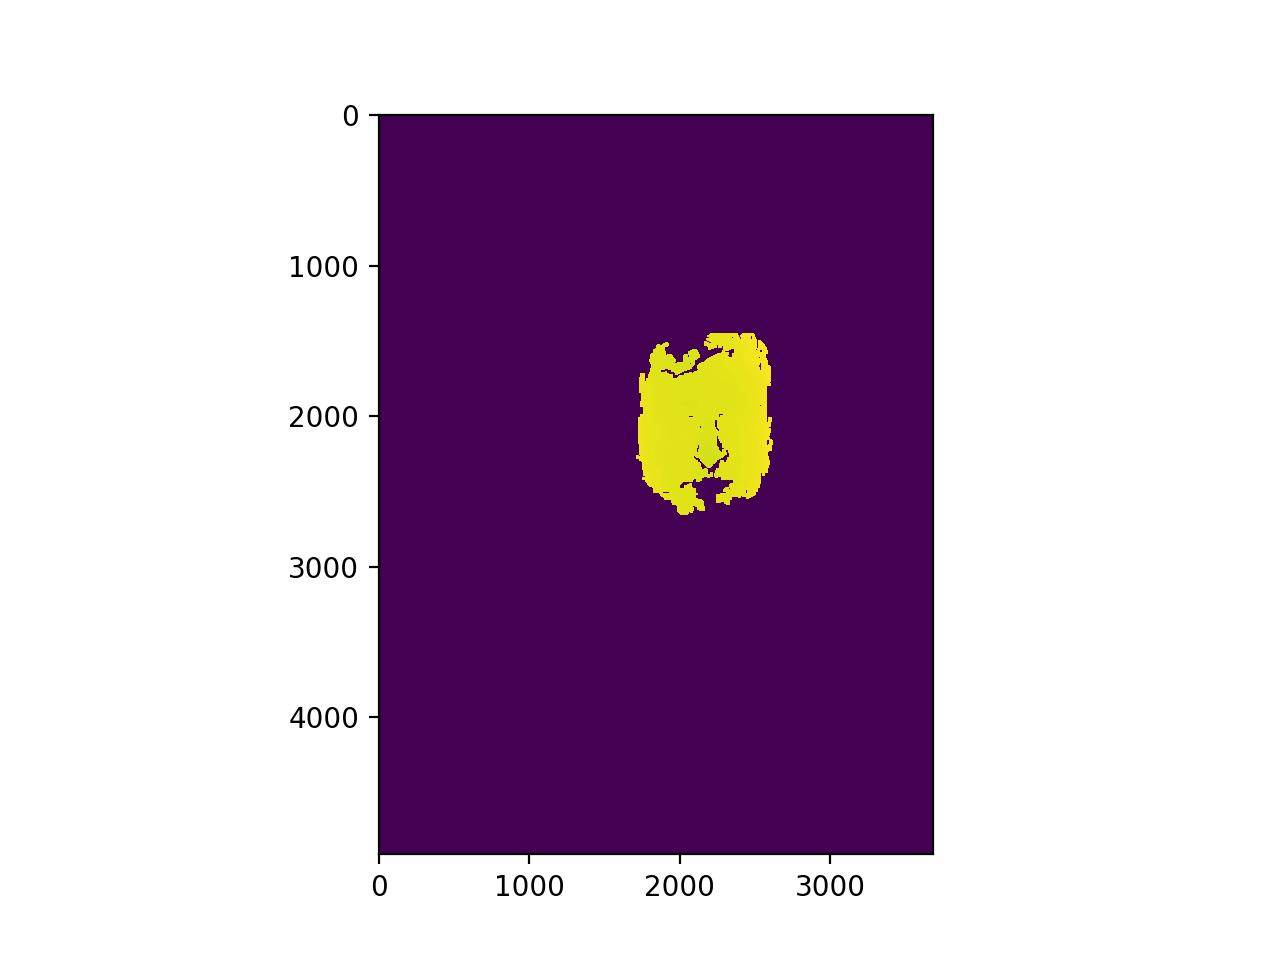

In [124]:
plt.figure()
plt.imshow(mask*XYZ[:,:,2])
plt.show()

<IPython.core.display.Javascript object>


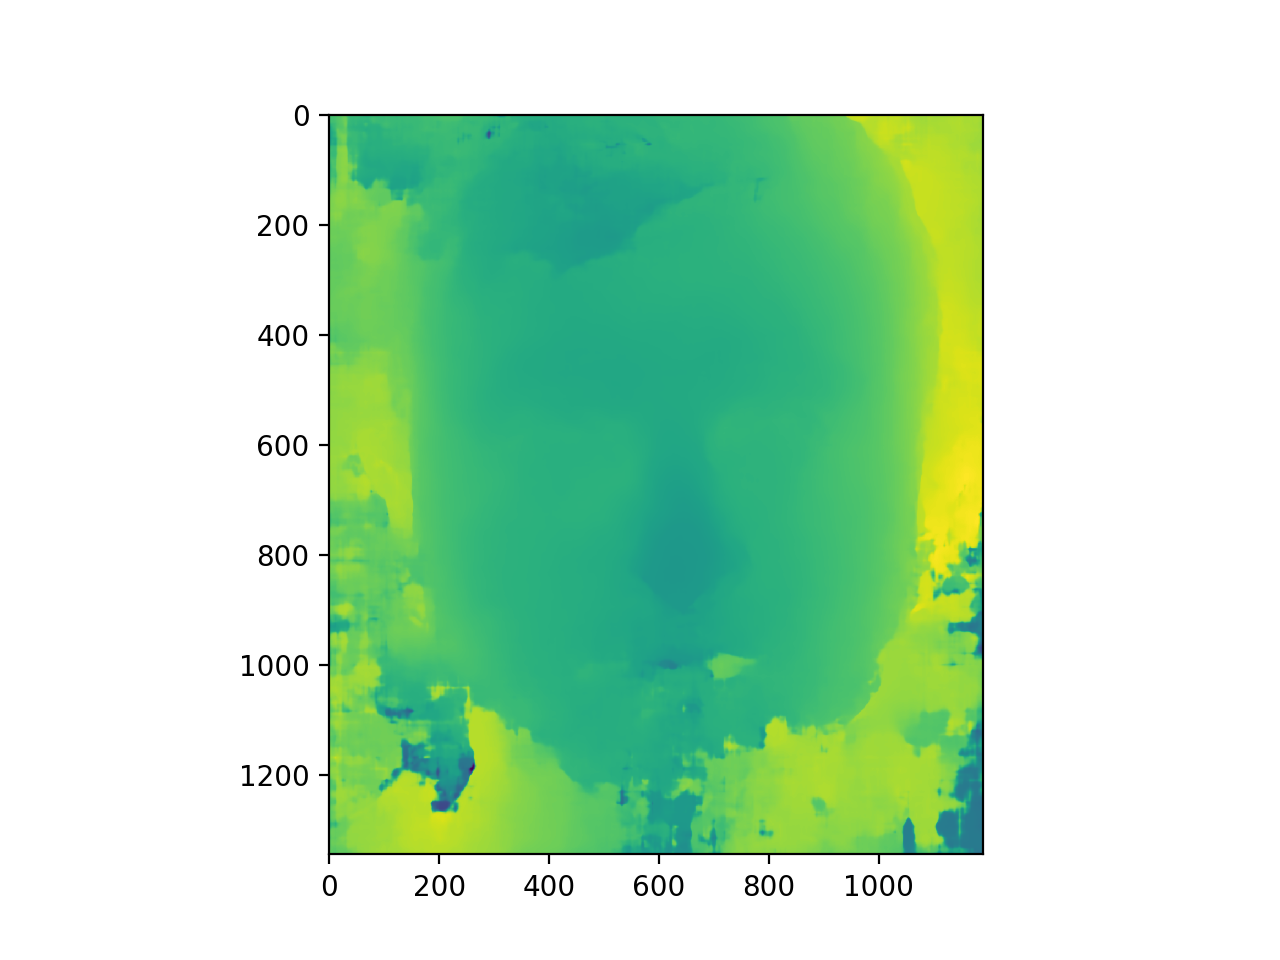

In [14]:
plt.figure()
plt.imshow(XYZ[min_y_l:max_y_l, (min_x_l-dispadd):(min_x_l-dispadd+imwidth),2])
plt.show()

In [10]:
gtdm = face0dm.data.copy()
gtdm = gtdm * 2.68

gtfa = dm2pc(gtdm, f, mask)

gtel = PlyElement.describe(gtfa, 'vertex')
PlyData([gtel], text=True).write('some_binary_gt.ply')

In [33]:
imgL = cv2.imread(imgL_path)
imgR = cv2.imread(imgR_path)
# imgL = cv2.resize(imgL,(disp.shape[0],disp.shape[1]))
# imgR = cv2.resize(imgR,(disp.shape[0],disp.shape[1]))
imgL2R = np.zeros((imgL.shape[0],imgL.shape[1],3), np.uint8)
for x in range(0, disp.shape[1]):
    for y in range(0, disp.shape[0]):
        if int(x-disp[y,x]+2)>0:
            imgL2R[y,int(x-disp[y,x]+2)] = imgL[y,x]

In [110]:
# imgL2R = cv2.resize(imgL2R,(1000,1000))
cv2.imwrite('face_render/facem02m005_10243.png', imgL2R)

True

In [35]:
imgL = imgL[:,::-1,:]

In [90]:
dm1 = dm

In [76]:
dm2 = dm

In [91]:
dm = (dm1+dm2)/2

In [17]:
path = '/home/vaheta/Downloads/Foto_03-05-2018'
for filename in os.listdir(path):
    if filename.endswith(".png"):
        
        tmp = cv2.imread(path+'/' + filename)
        newname = path+'/'+ os.path.splitext(os.path.basename(filename))[0] + '.jpg'
        print (newname)
        cv2.imwrite(newname, tmp)

/home/vaheta/Downloads/Foto_03-05-2018/2018-03-27_12-48-43_S1163138.jpg
/home/vaheta/Downloads/Foto_03-05-2018/2018-03-27_12-48-43_S1162720.jpg
/home/vaheta/Downloads/Foto_03-05-2018/2018-03-27_12-48-43_S1162750.jpg
/home/vaheta/Downloads/Foto_03-05-2018/2018-03-27_12-48-43_S1162721.jpg
/home/vaheta/Downloads/Foto_03-05-2018/2018-03-27_12-48-43_S1162717.jpg
/home/vaheta/Downloads/Foto_03-05-2018/2018-03-27_12-48-43_S1161313.jpg
/home/vaheta/Downloads/Foto_03-05-2018/2018-03-27_12-48-43_S1161322.jpg
/home/vaheta/Downloads/Foto_03-05-2018/2018-03-27_12-48-43_S1162722.jpg
/home/vaheta/Downloads/Foto_03-05-2018/2018-03-27_12-48-43_S1161318.jpg
/home/vaheta/Downloads/Foto_03-05-2018/2018-03-27_12-48-43_S1161314.jpg
/home/vaheta/Downloads/Foto_03-05-2018/2018-03-27_12-48-43_S1163131.jpg
/home/vaheta/Downloads/Foto_03-05-2018/2018-03-27_12-48-43_S1162716.jpg
/home/vaheta/Downloads/Foto_03-05-2018/2018-03-27_12-48-43_S1161321.jpg
/home/vaheta/Downloads/Foto_03-05-2018/2018-03-27_12-48-43_S1162

In [25]:
disp = np.load('lumix.npy')

In [5]:
calp = np.load ('26.05/calib_lr.npz')
lFrame = cv2.imread('26.05/for_rectification/left.png')
rFrame = cv2.imread('26.05/for_rectification/right.png')

img_shape = lFrame[:,:,0].shape[::-1]

(RCT1, RCT2, P1, P2, dsp2dm, ROI1, ROI2) = cv2.stereoRectify(
            calp['M1'], calp['d1'],
            calp['M2'], calp['d2'],
            img_shape, calp['R'], calp['T'],
            None, None, None, None, None,
            cv2.CALIB_ZERO_DISPARITY, alpha=-1)

In [7]:
dsp2dm


array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        -3.87430023e+03],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
        -2.25837462e+03],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         9.88490032e+03],
       [ 0.00000000e+00,  0.00000000e+00,  7.53438253e-03,
        -0.00000000e+00]])

In [4]:
(RCT1, RCT2, P1, P2, dsp2dm, ROI1, ROI2) = cv2.stereoRectify(
            calp['M1'], calp['d1'],
            calp['M2'], calp['d2'],
            img_shape, calp['R'], calp['T'],
            None, None, None, None, None,
            cv2.CALIB_ZERO_DISPARITY, alpha=-1)

NameError: name 'img_shape' is not defined

In [28]:
dmtemp = XYZ[min_y_l:max_y_l, (min_x_l-dispadd):(min_x_l-dispadd+imwidth),2]
laplacian = cv2.Laplacian(dmtemp,cv2.CV_32F)

sobelx = cv2.Sobel(dmtemp,cv2.CV_32F,1,0,ksize=5)
sobely = cv2.Sobel(dmtemp,cv2.CV_32F,0,1,ksize=5)

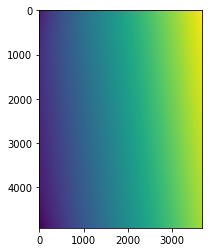

In [7]:
plt.figure()
plt.imshow(leftMapX)
# plt.clim(0,1)
plt.show()

In [117]:
maskoutn, maskout = cv2.connectedComponents(mask)
max = 0
for i in range(1, maskoutn):
    if len(maskout[maskout==i])>max:
        max = len(maskout[maskout==i])
        imax = i

In [119]:
mask[maskout!=imax] = 0